
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   timestamp                        32065 non-null  datetime64[ns]
 1   vehicle_gps_latitude             32065 non-null  float64       
 2   vehicle_gps_longitude            32065 non-null  float64       
 3   fuel_consumption_rate            32065 non-null  float64       
 4   eta_variation_hours              32065 non-null  float64       
 5   traffic_congestion_level         32065 non-null  float64       
 6   warehouse_inventory_level        32065 non-null  float64       
 7   loading_unloading_time           32065 non-null  float64       
 8   handling_equipment_availability  32065 non-null  float64       
 9   order_fulfillment_status         32065 non-null  float64       
 10  weather_condition_severity       32065 non-

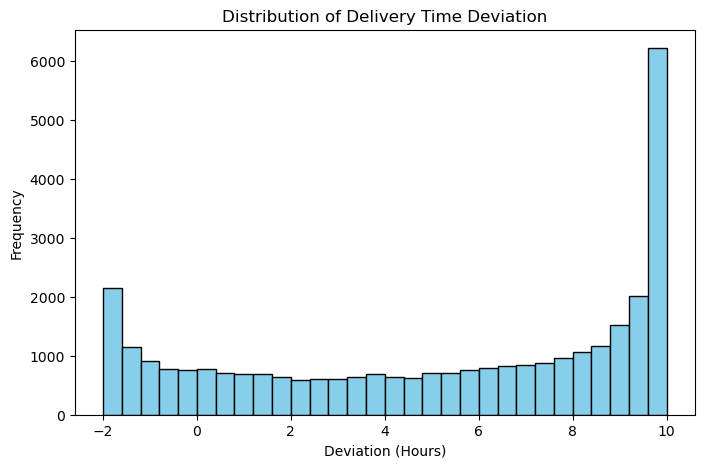

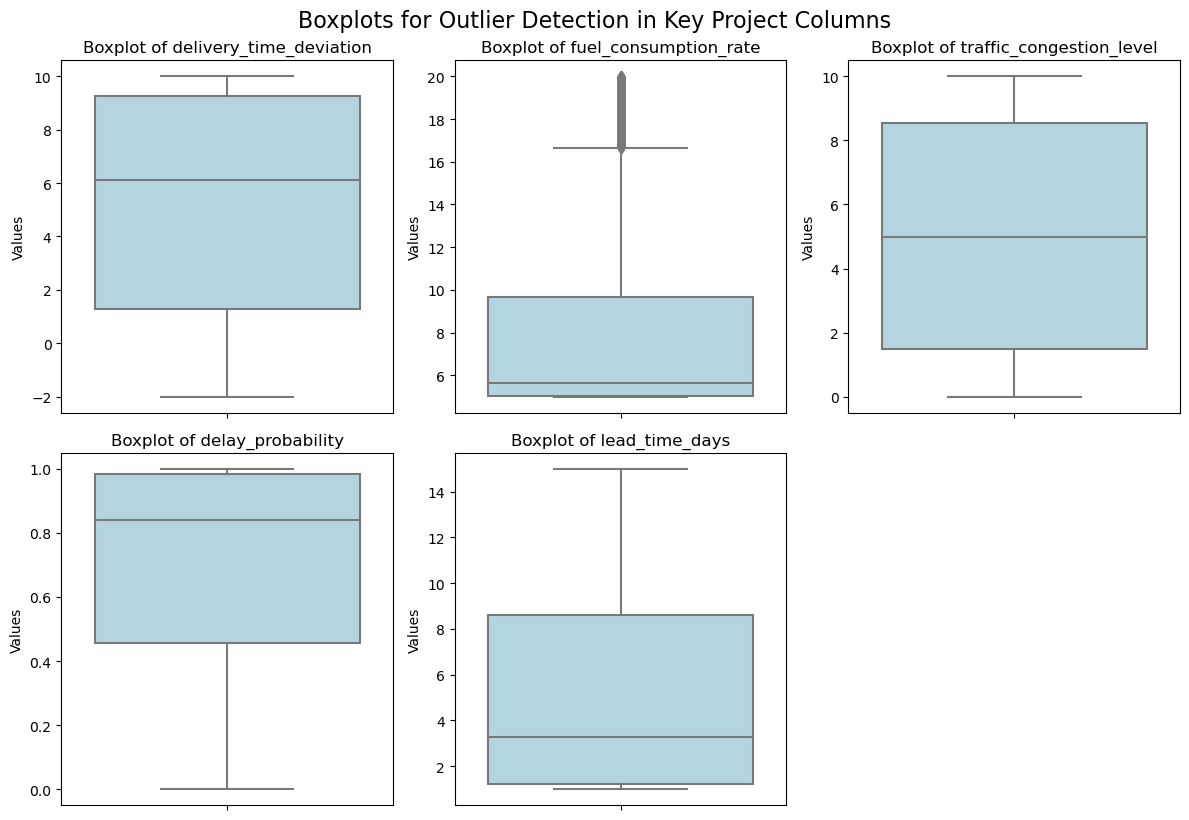

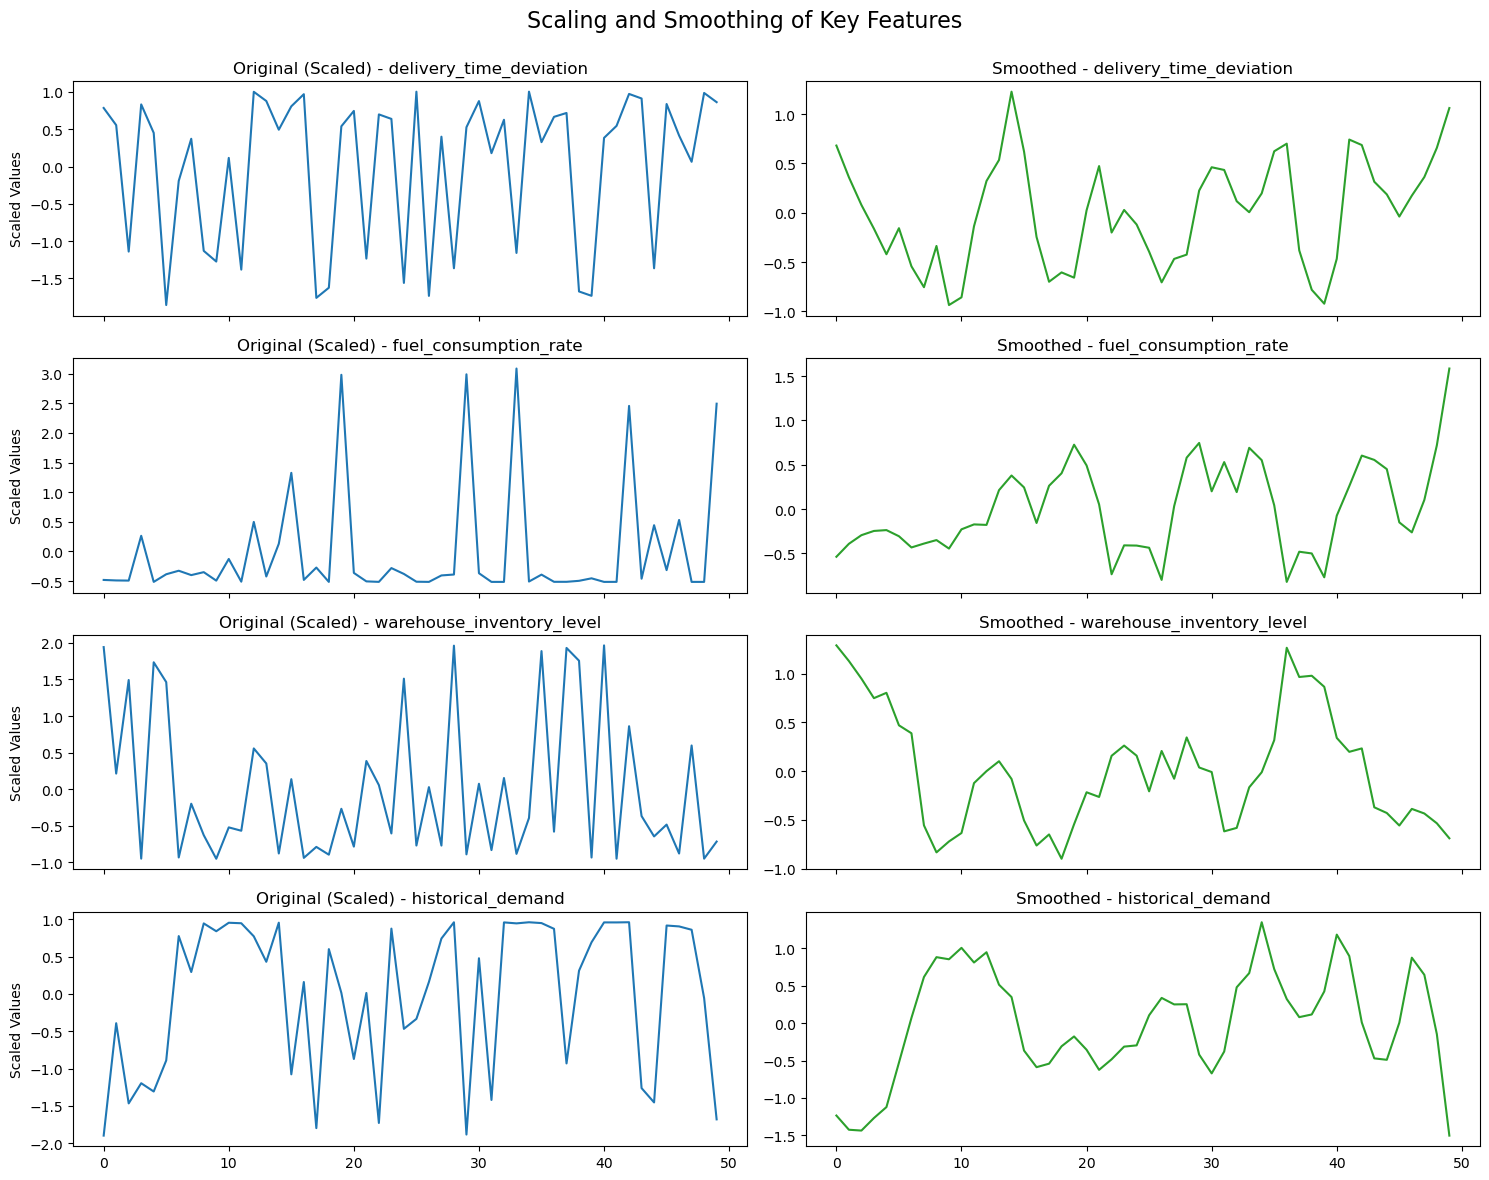

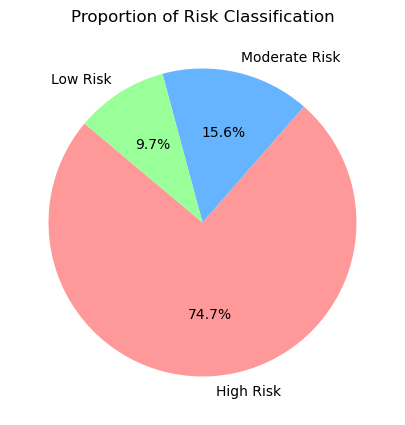

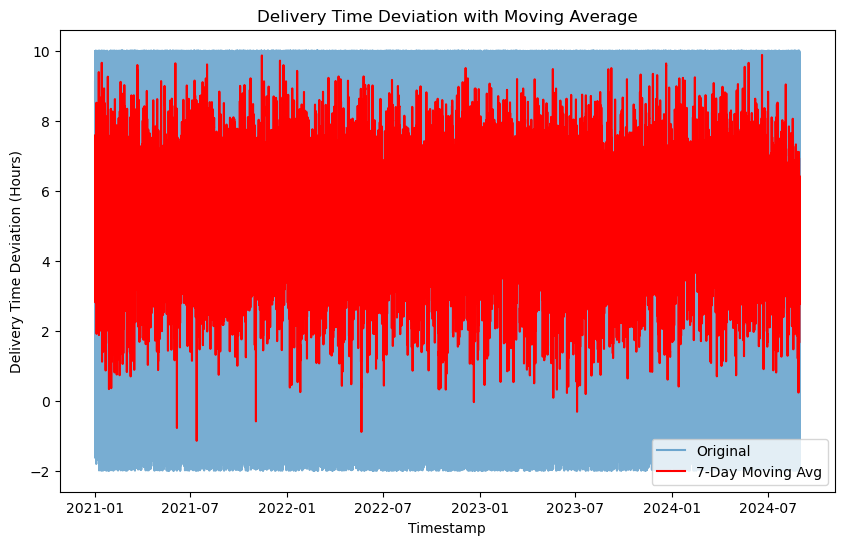

T-Test Results: t_stat=0.8290529907797866, p_val=0.4070817375092616

Chi-Square Test:
Chi2 Stat: 4.650881924965565, P-Value: 0.3250297127865549, Degrees of Freedom: 4
Expected Frequencies:
[[ 4581.9549041   4152.58331514 15209.46178076]
 [  595.1336348    539.36410416  1975.50226103]
 [  958.91146109   869.0525807   3183.03595821]]

Chi-Square Test Results for traffic congestion level and delay probability:
Chi2 Stat: 6.367052450021331, P-Value: 0.17336228527333883, Degrees of Freedom: 4

Expected Frequencies:
[[2410.38690161 2184.51133635 8001.10176205]
 [1344.31311399 1218.33853111 4462.3483549 ]
 [2381.29998441 2158.15013254 7904.54988305]]
Condition 1:
TPR: 0.50, FPR: 0.50, Posterior Probability: 49.41%

Condition 2:
TPR: 0.61, FPR: 0.61, Posterior Probability: 49.50%

Condition 2 (Port Congestion Level) is the better predictor of High Risk routes.


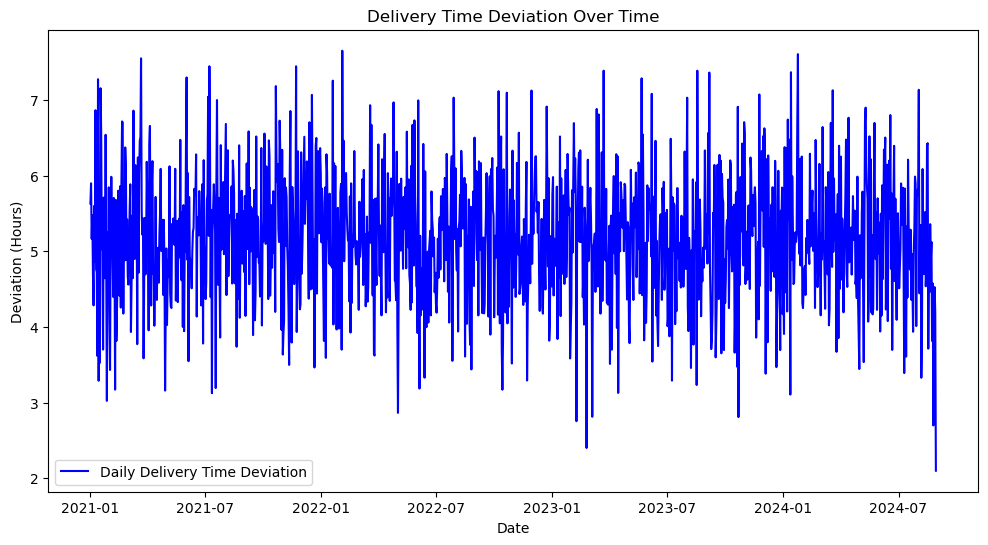

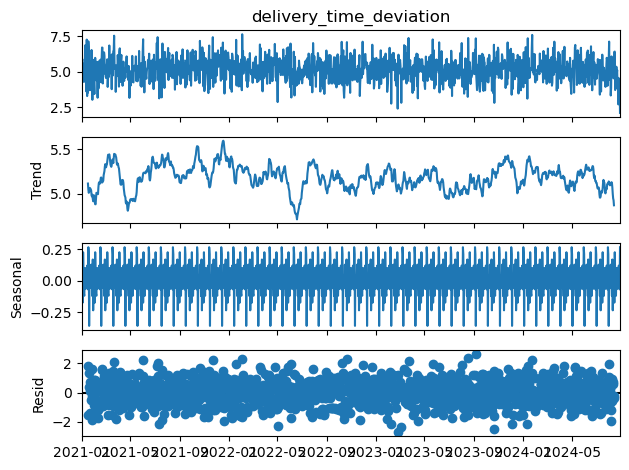

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48888D+00    |proj g|=  2.66464D-01

At iterate    5    f=  1.30037D+00    |proj g|=  8.26495D-02

At iterate   10    f=  1.26591D+00    |proj g|=  1.12560D-02

At iterate   15    f=  1.26089D+00    |proj g|=  5.40807D-03

At iterate   20    f=  1.26061D+00    |proj g|=  1.99771D-03

At iterate   25    f=  1.26060D+00    |proj g|=  2.41954D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

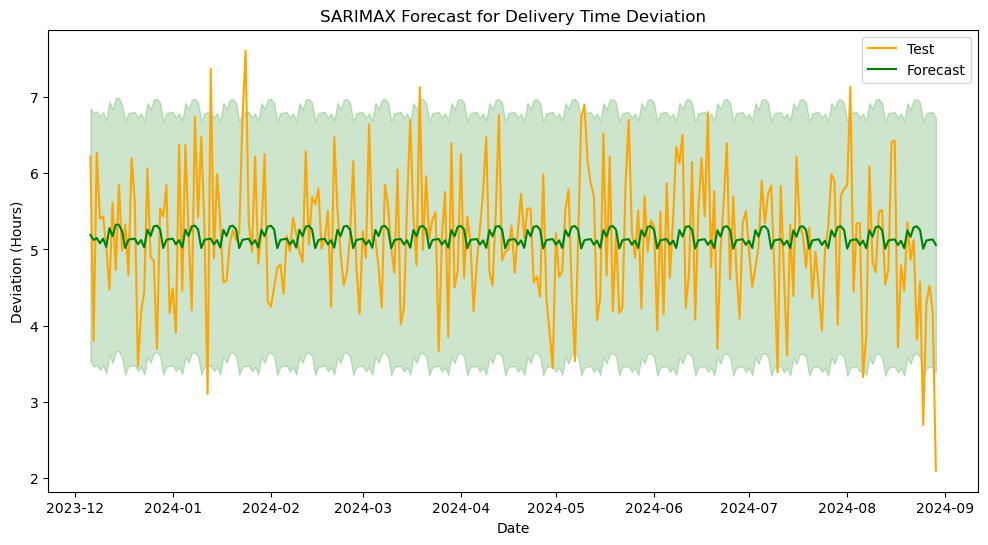

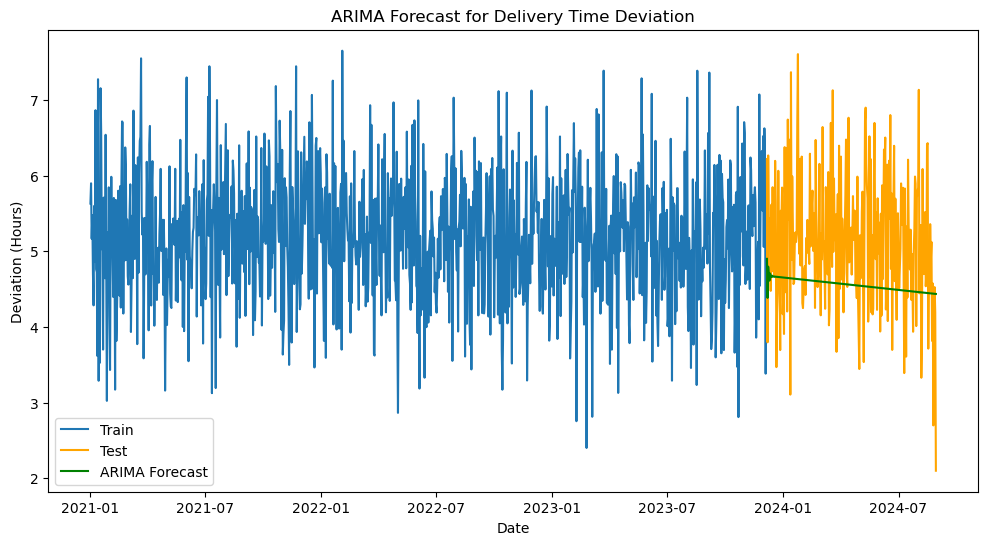

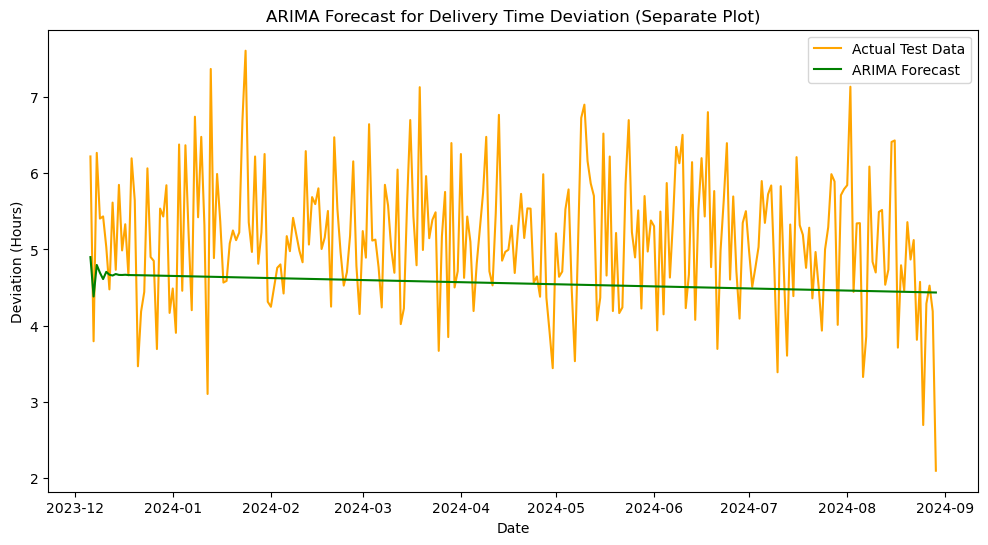

Supply-Demand Imbalance Matrix:
[[  884.94400773]
 [-4917.0379085 ]
 [ -762.64021145]
 ...
 [ -551.63189317]
 [ -382.00016358]
 [-9725.95509435]]
Canonical Equation for Operational Metrics (X):
X_canonical = (-0.974) * fuel_consumption_rate + (-0.227) * traffic_congestion_level + (0.008) * warehouse_inventory_level

Canonical Equation for Outcome Metrics (Y):
Y_canonical = (0.077) * delivery_time_deviation + (-0.993) * delay_probability + (-0.084) * lead_time_days

Pearson Correlation between Canonical Variates: -0.027

Canonical Loadings for Operational Metrics (X):
[-0.83148201 -0.16001559  0.52831856]

Canonical Loadings for Outcome Metrics (Y):
[ 0.54002307 -0.54052833 -0.64454003]

Cross-Loadings for Operational Metrics (X):
[-0.01446858  0.01448212  0.01726885]

Cross-Loadings for Outcome Metrics (Y):
[ 0.0222775   0.00428722 -0.01415499]


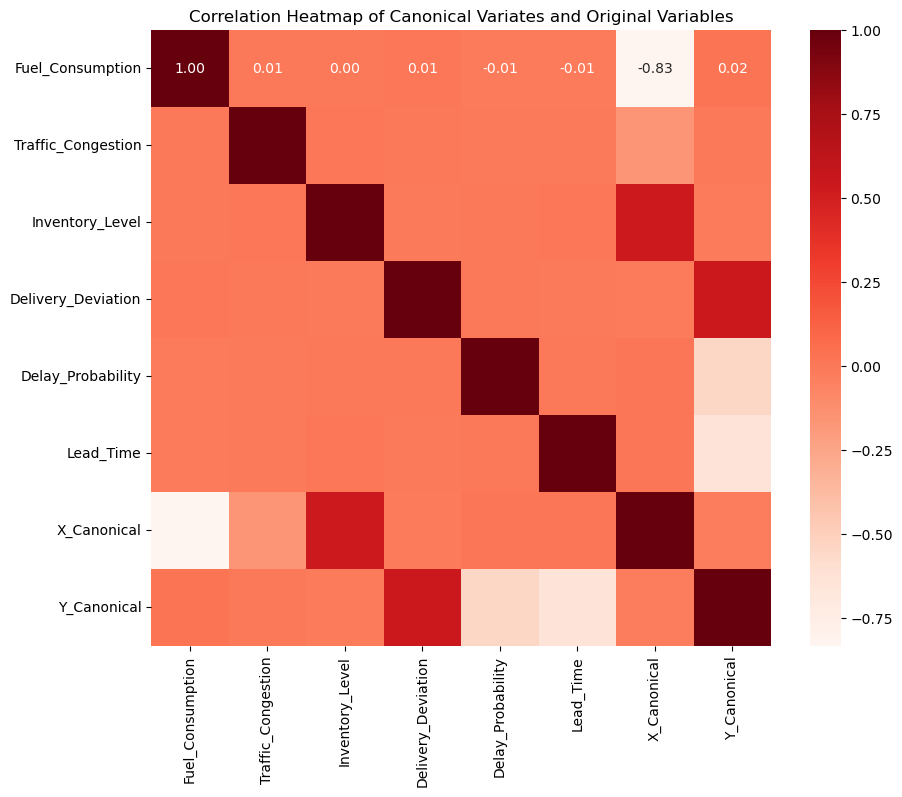

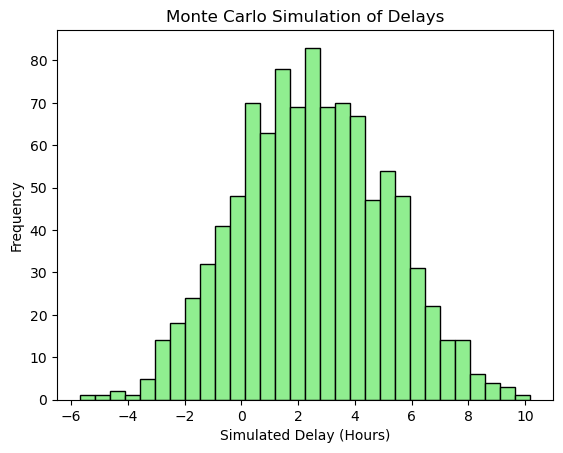

DTW Distance between Delivery Time Deviation and Fuel Consumption Rate: 370.3662232155366


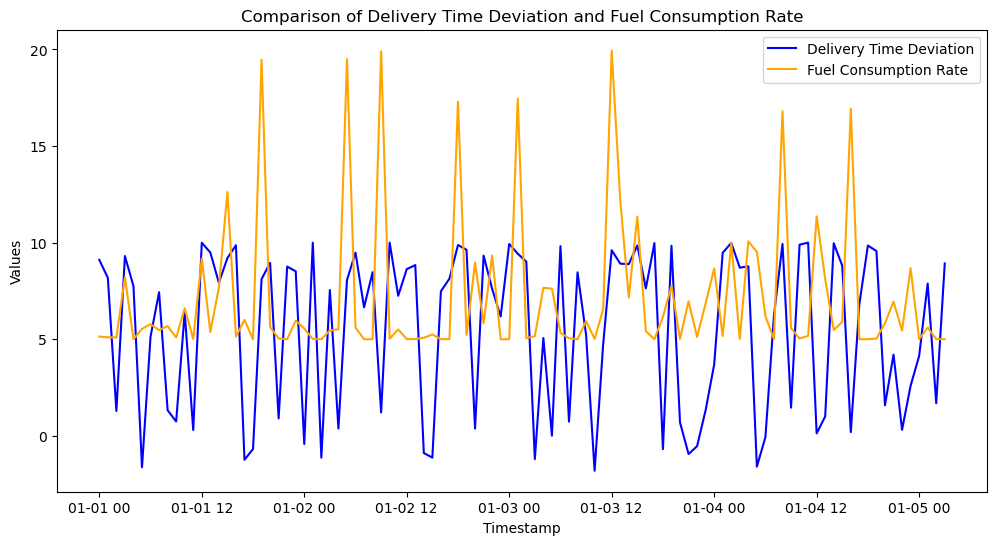

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, normaltest, ks_2samp
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

# Load dataset
data = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure timestamp is datetime

# ---------------------------- 1. Exploratory Data Analysis ----------------------------

# Scaling Example
data_scaled = StandardScaler().fit_transform(data[['delivery_time_deviation', 'fuel_consumption_rate']])
data_scaled = pd.DataFrame(data_scaled, columns=['delivery_time_deviation', 'fuel_consumption_rate'])

# Overview of the dataset
print("\nDataset Info:")
print(data.info())

# Check for missing values
missing_values = data.isnull().sum()
#print("\nMissing Values in Each Column:")
#print(missing_values)

# Distribution of Delivery Time Deviation
plt.figure(figsize=(8, 5))
plt.hist(data['delivery_time_deviation'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Delivery Time Deviation')
plt.xlabel('Deviation (Hours)')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Delivery Time Deviation grouped by Risk Classification
# Selected columns for boxplots
selected_columns = [
    'delivery_time_deviation', 
    'fuel_consumption_rate', 
    'traffic_congestion_level', 
    'delay_probability', 
    'lead_time_days'
]

# Boxplots for selected columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(selected_columns, 1):
    plt.subplot(2, 3, i)  # Adjust layout for 2 rows, 3 columns
    sns.boxplot(y=data[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')
    plt.tight_layout()

plt.suptitle('Boxplots for Outlier Detection in Key Project Columns', y=1.02, fontsize=16)
plt.show()


# Pairplot of selected features
# Select the first 50 rows of key features
subset_data = data[['delivery_time_deviation', 'fuel_consumption_rate', 
                    'warehouse_inventory_level', 'historical_demand']].iloc[:50]

# Scale the data
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(subset_data), 
                           columns=subset_data.columns, 
                           index=subset_data.index)

# Smooth and detrend the data
smoothed_data = scaled_data.apply(lambda x: savgol_filter(x, window_length=7, polyorder=2))
detrended_data = scaled_data.diff().dropna()

# Plot original, smoothed, and detrended data
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12), sharex=True)

for i, column in enumerate(subset_data.columns):
    # Original Data
    axes[i, 0].plot(subset_data.index, scaled_data[column], color='tab:blue')
    axes[i, 0].set_title(f"Original (Scaled) - {column}")
    axes[i, 0].set_ylabel('Scaled Values')

    # Smoothed Data
    axes[i, 1].plot(subset_data.index, smoothed_data[column], color='tab:green')
    axes[i, 1].set_title(f"Smoothed - {column}")

    # Detrended Data
 #   axes[i, 2].plot(subset_data.index[1:], detrended_data[column], color='tab:red')
 #   axes[i, 2].set_title(f"Detrended - {column}")

# Add common labels
fig.suptitle('Scaling and Smoothing of Key Features', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

# Risk Classification Proportions
risk_proportions = data['risk_classification'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 5))
risk_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Proportion of Risk Classification')
plt.ylabel('')
plt.show()

# Moving Average for Delivery Time Deviation
data['delivery_time_moving_avg'] = data['delivery_time_deviation'].rolling(window=7).mean()
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['delivery_time_deviation'], label='Original', alpha=0.6)
plt.plot(data['timestamp'], data['delivery_time_moving_avg'], label='7-Day Moving Avg', color='red')
plt.title('Delivery Time Deviation with Moving Average')
plt.xlabel('Timestamp')
plt.ylabel('Delivery Time Deviation (Hours)')
plt.legend()
plt.show()


# -------------------- 2. Statistical Testing and Bayesian Analysis -----------------
# T-test: High Risk vs Low Risk for Delivery Time Deviation
high_risk = data[data['risk_classification'] == 'High Risk']['delivery_time_deviation']
low_risk = data[data['risk_classification'] == 'Low Risk']['delivery_time_deviation']
t_stat, p_val = ttest_ind(high_risk, low_risk)
print(f"T-Test Results: t_stat={t_stat}, p_val={p_val}")


from scipy.stats import chi2_contingency

# Create a contingency table for Chi-Square Test
data['delay_probability_binned'] = pd.cut(data['delay_probability'], bins=3, labels=['Low', 'Medium', 'High'])
contingency_table = pd.crosstab(data['risk_classification'], data['delay_probability_binned'])

# Perform the Chi-Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Test:")
print(f"Chi2 Stat: {chi2_stat}, P-Value: {p_val}, Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

import pandas as pd
from scipy.stats import chi2_contingency

# Assuming 'data' is your DataFrame
# Bin the warehouse_inventory_level into categories
data['traffic_congestion_level_binned'] = pd.cut(data['traffic_congestion_level'], bins=3, labels=['Low', 'Medium', 'High'])

# Bin the delay_probability into categories (you have already done this step)
data['delay_probability_binned'] = pd.cut(data['delay_probability'], bins=3, labels=['Low', 'Medium', 'High'])

# Create a contingency table for the Chi-Square Test
contingency_table = pd.crosstab(data['traffic_congestion_level_binned'], data['delay_probability_binned'])

# Perform the Chi-Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("\nChi-Square Test Results for traffic congestion level and delay probability:")
print(f"Chi2 Stat: {chi2_stat}, P-Value: {p_val}, Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)



# Simulate binary test conditions based on thresholds
# Test condition: High traffic congestion and high port congestion
data['test_condition1'] = np.where(data['traffic_congestion_level'] > data['traffic_congestion_level'].mean(), 1, -1)
data['test_condition2'] = np.where(data['port_congestion_level'] > data['port_congestion_level'].mean(), 1, -1)

# Actual risk classification (ground truth)
data['actual_risk'] = np.where(data['risk_classification'] == 'High Risk', 1, -1)

# Function to calculate metrics
def evaluate_condition(test_condition, actual_risk):
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(test_condition)):
        if test_condition[i] == 1 and actual_risk[i] == 1:
            TP += 1
        if test_condition[i] == -1 and actual_risk[i] == -1:
            TN += 1
        if test_condition[i] == 1 and actual_risk[i] == -1:
            FP += 1
        if test_condition[i] == -1 and actual_risk[i] == 1:
            FN += 1
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # True positive rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False positive rate
    return TPR, FPR, TP, FP, TN, FN

# Evaluate test conditions
TPR1, FPR1, TP1, FP1, TN1, FN1 = evaluate_condition(data['test_condition1'], data['actual_risk'])
TPR2, FPR2, TP2, FP2, TN2, FN2 = evaluate_condition(data['test_condition2'], data['actual_risk'])

# Bayesian inference
P_AbyN = data['actual_risk'].mean()  # Probability of a route being High Risk (prior)

# Condition 1
P_E1_and_A = P_AbyN * TPR1
P_E1_and_Aneg = (1 - P_AbyN) * FPR1
P_E1 = P_E1_and_A + P_E1_and_Aneg
P_acc1 = P_E1_and_A / P_E1

# Condition 2
P_E2_and_A = P_AbyN * TPR2
P_E2_and_Aneg = (1 - P_AbyN) * FPR2
P_E2 = P_E2_and_A + P_E2_and_Aneg
P_acc2 = P_E2_and_A / P_E2

# Display Results
print("Condition 1:")
print(f"TPR: {TPR1:.2f}, FPR: {FPR1:.2f}, Posterior Probability: {P_acc1 * 100:.2f}%")
print("\nCondition 2:")
print(f"TPR: {TPR2:.2f}, FPR: {FPR2:.2f}, Posterior Probability: {P_acc2 * 100:.2f}%")

# Decision
if P_acc1 > P_acc2:
    print("\nCondition 1 (Traffic Congestion Level) is the better predictor of High Risk routes.")
else:
    print("\nCondition 2 (Port Congestion Level) is the better predictor of High Risk routes.")





# ----------------------------- 3. Time-Series Analysis -----------------------------
# ------------------------ 1. Time-Series Analysis -------------------------
# Setting timestamp as the index
data = data.set_index('timestamp')

# Resample delivery_time_deviation to daily averages
daily_time_series = data['delivery_time_deviation'].resample('D').mean().dropna()

# Line plot for Delivery Time Deviation
plt.figure(figsize=(12, 6))
plt.plot(daily_time_series, color='blue', label='Daily Delivery Time Deviation')
plt.title('Delivery Time Deviation Over Time')
plt.xlabel('Date')
plt.ylabel('Deviation (Hours)')
plt.legend()
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(daily_time_series, model='additive', period=30)
decomposition.plot()
plt.show()

# SARIMAX Model for Forecasting
train = daily_time_series[:int(0.8 * len(daily_time_series))]
test = daily_time_series[int(0.8 * len(daily_time_series)):]
sarimax_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
results = sarimax_model.fit()

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot Train, Test, and Forecast
plt.figure(figsize=(12, 6))
plt.plot(test, label='Test', color='orange')
plt.plot(forecast_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title('SARIMAX Forecast for Delivery Time Deviation')
plt.xlabel('Date')
plt.ylabel('Deviation (Hours)')
plt.legend()
plt.show()

from statsmodels.tsa.arima.model import ARIMA

# Resample delivery_time_deviation to daily averages
daily_time_series = data['delivery_time_deviation'].resample('D').mean().dropna()

# Split into train and test sets
train_arima = daily_time_series[:int(0.8 * len(daily_time_series))]
test_arima = daily_time_series[int(0.8 * len(daily_time_series)):]

# Fit the ARIMA model
arima_model = ARIMA(train_arima, order=(2, 2, 1))
arima_results = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_results.forecast(steps=len(test_arima))

# Plot ARIMA Results
plt.figure(figsize=(12, 6))
plt.plot(train_arima, label='Train')
plt.plot(test_arima, label='Test', color='orange')
plt.plot(test_arima.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast for Delivery Time Deviation')
plt.xlabel('Date')
plt.ylabel('Deviation (Hours)')
plt.legend()
plt.show()

# Separate plot for the ARIMA forecast
plt.figure(figsize=(12, 6))

# Plot only the test data and the forecast
plt.plot(test_arima.index, test_arima, label='Actual Test Data', color='orange')
plt.plot(test_arima.index, arima_forecast, label='ARIMA Forecast', color='green')

# Add labels, title, and legend
plt.title('ARIMA Forecast for Delivery Time Deviation (Separate Plot)')
plt.xlabel('Date')
plt.ylabel('Deviation (Hours)')
plt.legend()

# Show the plot
plt.show()


# ------------------ 4. Matrix Algebra for Supply-Demand Optimization ------------------
# Supply-Demand Imbalance
data['supply_demand_diff'] = data['warehouse_inventory_level'] - data['historical_demand']
imbalance_matrix = np.array(data['supply_demand_diff']).reshape(-1, 1)
print("Supply-Demand Imbalance Matrix:")
print(imbalance_matrix)

# ---------------------- 5. Canonical Correlation Analysis (CCA) -----------------------
 
# Define two sets of features for Canonical Correlation Analysis (CCA)
# Set X: Operational Metrics (Independent Variables)
X = np.array([data['fuel_consumption_rate'], 
              data['traffic_congestion_level'], 
              data['warehouse_inventory_level']])

# Set Y: Outcome Metrics (Dependent Variables)
Y = np.array([data['delivery_time_deviation'], 
              data['delay_probability'], 
              data['lead_time_days']])

# Covariance matrices
Rxx = np.cov(X)
Ryy = np.cov(Y)
R = np.cov(np.vstack((X, Y)))  # Combined covariance matrix

# Extract cross-covariance matrices
Rxy = R[:3, 3:]
Ryx = Rxy.T

# Inverses of Rxx and Ryy
Rxx_inv = np.linalg.inv(Rxx)
Ryy_inv = np.linalg.inv(Ryy)

# Canonical correlation matrix
A = np.matmul(Rxx_inv, Rxy)
B = np.matmul(Ryy_inv, Ryx)
Rx = np.matmul(A, B)

# Eigenvalues and eigenvectors (Canonical Correlations)
eigenvalues, eigenvectors_X = np.linalg.eig(Rx)

# Canonical Equation for X
print("Canonical Equation for Operational Metrics (X):")
print(f"X_canonical = ({eigenvectors_X[0, 0]:.3f}) * fuel_consumption_rate + "
      f"({eigenvectors_X[1, 0]:.3f}) * traffic_congestion_level + "
      f"({eigenvectors_X[2, 0]:.3f}) * warehouse_inventory_level\n")

# Canonical Equation for Y
A1 = np.matmul(Ryy_inv, Ryx)
B1 = np.matmul(Rxx_inv, Rxy)
Rx_Y = np.matmul(A1, B1)
_, eigenvectors_Y = np.linalg.eig(Rx_Y)
print("Canonical Equation for Outcome Metrics (Y):")
print(f"Y_canonical = ({eigenvectors_Y[0, 0]:.3f}) * delivery_time_deviation + "
      f"({eigenvectors_Y[1, 0]:.3f}) * delay_probability + "
      f"({eigenvectors_Y[2, 0]:.3f}) * lead_time_days\n")

# Canonical Variates
X_canonical = eigenvectors_X[:, 0].T @ X
Y_canonical = eigenvectors_Y[:, 0].T @ Y

# Standardize Canonical Variates
scaler = StandardScaler()
X_canonical_std = scaler.fit_transform(X_canonical.reshape(-1, 1))
Y_canonical_std = scaler.fit_transform(Y_canonical.reshape(-1, 1))

# Pearson Correlation between Canonical Variates
corr, _ = pearsonr(X_canonical_std.squeeze(), Y_canonical_std.squeeze())
print(f"Pearson Correlation between Canonical Variates: {corr:.3f}")

# Canonical Loadings (correlations with original variables)
canonical_loadings_X = np.array([
    pearsonr(X_canonical_std.squeeze(), X[i])[0] for i in range(3)
])
canonical_loadings_Y = np.array([
    pearsonr(Y_canonical_std.squeeze(), Y[i])[0] for i in range(3)
])

print("\nCanonical Loadings for Operational Metrics (X):")
print(canonical_loadings_X)

print("\nCanonical Loadings for Outcome Metrics (Y):")
print(canonical_loadings_Y)

# Cross-Loadings (correlations between canonical variates and opposite set variables)
cross_loadings_X = np.array([
    pearsonr(X_canonical_std.squeeze(), Y[i])[0] for i in range(3)
])
cross_loadings_Y = np.array([
    pearsonr(Y_canonical_std.squeeze(), X[i])[0] for i in range(3)
])

print("\nCross-Loadings for Operational Metrics (X):")
print(cross_loadings_X)

print("\nCross-Loadings for Outcome Metrics (Y):")
print(cross_loadings_Y)

# Correlation Matrix and Heatmap
data_combined = np.vstack((X, Y, X_canonical_std.squeeze(), Y_canonical_std.squeeze())).T
cols = ['Fuel_Consumption', 'Traffic_Congestion', 'Inventory_Level',
        'Delivery_Deviation', 'Delay_Probability', 'Lead_Time',
        'X_Canonical', 'Y_Canonical']

# Compute correlation matrix
cm = np.corrcoef(data_combined.T)

# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=cols, yticklabels=cols, cmap='Reds', fmt=".2f")
plt.title("Correlation Heatmap of Canonical Variates and Original Variables")
plt.show()

# ----------- 6. Discrete and Continuous Data Analysis (Probability Distributions) -----


# ------------------------- 7. Monte Carlo Simulation ---------------------------------
def monte_carlo_simulation(trials=1000):
    simulated_delays = []
    for _ in range(trials):
        traffic_level = np.random.choice(data['traffic_congestion_level'])
        delay = np.random.normal(loc=traffic_level * 0.5, scale=2)
        simulated_delays.append(delay)
    return simulated_delays

simulated_delays = monte_carlo_simulation()
plt.hist(simulated_delays, bins=30, color='lightgreen', edgecolor='black')
plt.title('Monte Carlo Simulation of Delays')
plt.xlabel('Simulated Delay (Hours)')
plt.ylabel('Frequency')
plt.show()

# ---------------------------- 8. Dynamic Time Warping (DTW) --------------------------
#data['timestamp'] = pd.to_datetime(data['timestamp'])
#data = data.set_index('timestamp')

# Extract two real metrics for DTW analysis
series1 = data['delivery_time_deviation'].dropna().iloc[:100]  # First 100 points
series2 = data['fuel_consumption_rate'].dropna().iloc[:100]    # First 100 points

# Define DTW function
def dtw_distance(series1, series2):
    l_s_1, l_s_2 = len(series1), len(series2)
    cost_matrix = np.zeros((l_s_1+1, l_s_2+1))
    cost_matrix[0, :] = np.inf
    cost_matrix[:, 0] = np.inf
    cost_matrix[0, 0] = 0
    
    for i in range(1, l_s_1+1):
        for j in range(1, l_s_2+1):
            cost = abs(series1.iloc[i-1] - series2.iloc[j-1])
            cost_matrix[i, j] = cost + min(
                cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]
            )
    return cost_matrix[-1, -1]

# Calculate DTW distance
dtw_result = dtw_distance(series1, series2)
print(f"DTW Distance between Delivery Time Deviation and Fuel Consumption Rate: {dtw_result}")

# Plot the two series for visual comparison
plt.figure(figsize=(12, 6))
plt.plot(series1.index, series1, label='Delivery Time Deviation', color='blue')
plt.plot(series2.index, series2, label='Fuel Consumption Rate', color='orange')
plt.title('Comparison of Delivery Time Deviation and Fuel Consumption Rate')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()


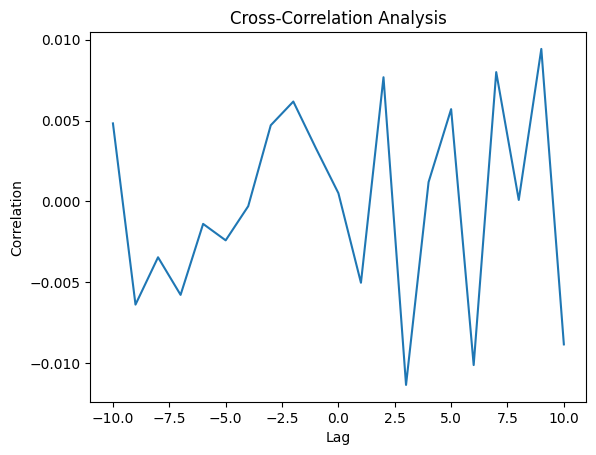

Risk Scores Calculated for Each Row:
                     traffic_congestion_level  delay_probability  \
timestamp                                                          
2021-01-01 00:00:00                  5.927586           0.885291   
2021-01-01 01:00:00                  1.591992           0.544178   
2021-01-01 02:00:00                  8.787765           0.803322   
2021-01-01 03:00:00                  0.045257           0.025977   
2021-01-01 04:00:00                  8.004851           0.991122   
...                                       ...                ...   
2024-08-28 20:00:00                  0.192421           0.916745   
2024-08-28 21:00:00                  8.736143           0.808963   
2024-08-28 22:00:00                  7.420200           0.959197   
2024-08-28 23:00:00                  0.932050           0.557340   
2024-08-29 00:00:00                  7.156608           0.999230   

                     port_congestion_level  risk_score  
timestamp            

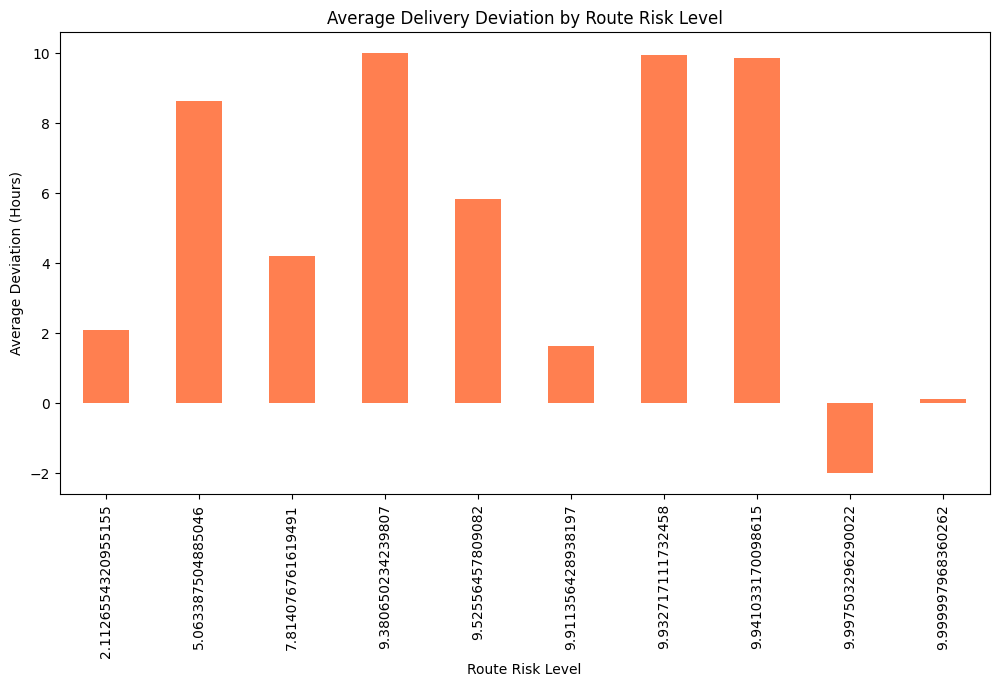

Redistribution Plan:
                             route_risk_level  supply_demand_diff
        timestamp                                                
Surplus 2021-01-01 00:00:00          1.182116          884.944008
        2021-01-03 14:00:00          6.328277          734.286021
        2021-01-04 00:00:00          9.893624          792.578413
        2021-01-04 23:00:00          2.427861          127.186057
        2021-01-05 11:00:00          3.386169          220.714264
...                                       ...                 ...
Deficit 2024-08-28 20:00:00          9.893402          -77.997831
        2024-08-28 21:00:00          0.854378        -1027.322135
        2024-08-28 22:00:00          4.480552         -551.631893
        2024-08-28 23:00:00          9.185549         -382.000164
        2024-08-29 00:00:00          2.112655        -9725.955094

[32065 rows x 2 columns]
KS Test for Normal Distribution: stat=0.1266178075783565, p=1.6405792222859157e-224
KS Test for

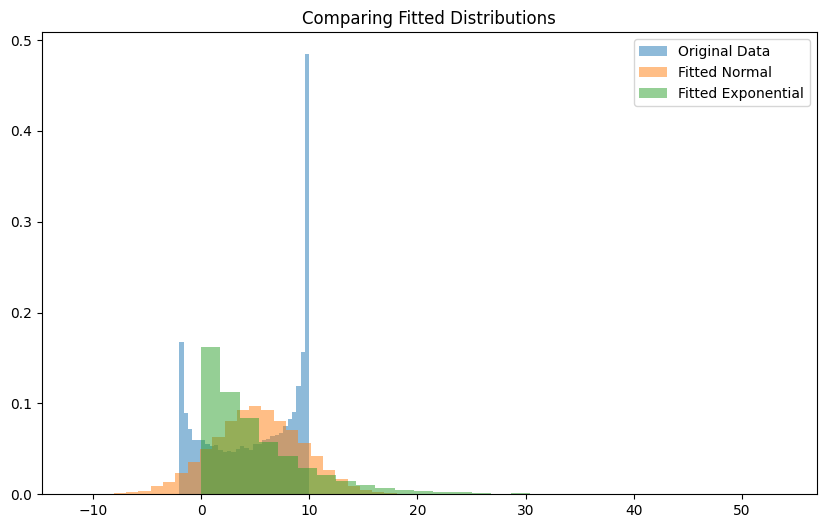

In [7]:
# --------------------------- 9. Cross-Correlation Analysis ---------------------------
def cross_correlation(series1, series2, lag=10):
    correlations = [series1.corr(series2.shift(l)) for l in range(-lag, lag + 1)]
    plt.plot(range(-lag, lag + 1), correlations)
    plt.title('Cross-Correlation Analysis')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()

cross_correlation(data['traffic_congestion_level'], data['delivery_time_deviation'])

# --------------------------- 10. Advanced Risk Scoring --------------------------------


# ---------------------------- 11. Heatmap of Grouped Trends --------------------------
# Use 'route_risk_level' as a proxy for region

#data_grouped = data.groupby('route_risk_level')['delivery_time_deviation'].mean()
#data_grouped.plot(kind='bar', figsize=(12, 6), color='coral', title='Average Delivery Deviation by Route Risk Level')
#plt.xlabel('Route Risk Level')
#plt.ylabel('Average Deviation (Hours)')
#plt.show()

# Limit the route_risk_level to top categories for clarity
top_levels = data['route_risk_level'].value_counts().index[:10]  # Top 10 levels
filtered_data = data[data['route_risk_level'].isin(top_levels)]

# Group and plot
data_grouped = filtered_data.groupby('route_risk_level')['delivery_time_deviation'].mean()
data_grouped.plot(kind='bar', figsize=(12, 6), color='coral', title='Average Delivery Deviation by Route Risk Level')
plt.xlabel('Route Risk Level')
plt.ylabel('Average Deviation (Hours)')
plt.show()



# --------------------------- 16. Analyzing Probability Distributions -------------------
data['fitted_normal'] = np.random.normal(loc=data['delivery_time_deviation'].mean(), scale=data['delivery_time_deviation'].std(), size=len(data))
data['fitted_exponential'] = np.random.exponential(scale=data['delivery_time_deviation'].mean(), size=len(data))

# Goodness-of-Fit for Normal and Exponential
normal_ks = ks_2samp(data['delivery_time_deviation'], data['fitted_normal'])
exp_ks = ks_2samp(data['delivery_time_deviation'], data['fitted_exponential'])
print(f"KS Test for Normal Distribution: stat={normal_ks.statistic}, p={normal_ks.pvalue}")
print(f"KS Test for Exponential Distribution: stat={exp_ks.statistic}, p={exp_ks.pvalue}")

plt.figure(figsize=(10, 6))
plt.hist(data['delivery_time_deviation'], bins=30, alpha=0.5, label='Original Data', density=True)
plt.hist(data['fitted_normal'], bins=30, alpha=0.5, label='Fitted Normal', density=True)
plt.hist(data['fitted_exponential'], bins=30, alpha=0.5, label='Fitted Exponential', density=True)
plt.legend()
plt.title('Comparing Fitted Distributions')
plt.show()


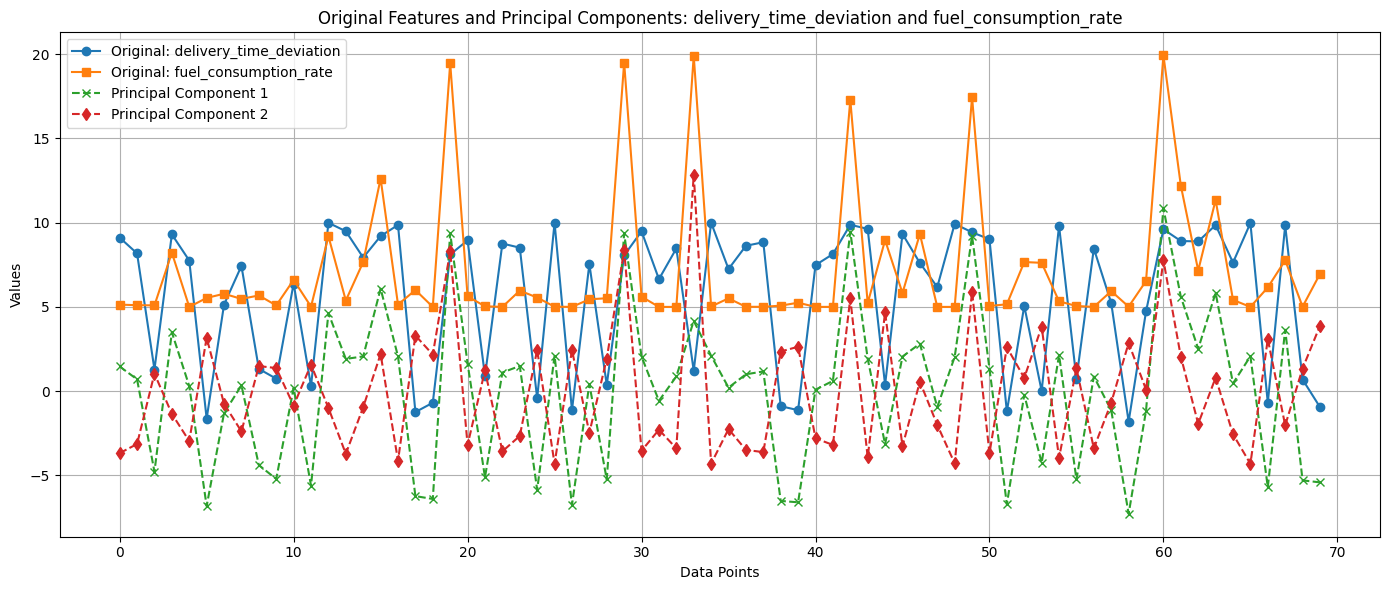


Pair: ('delivery_time_deviation', 'fuel_consumption_rate')
Eigenvalues:
[20.37051599 13.4847703 ]

Eigenvectors:
[[ 0.79399653 -0.60792229]
 [ 0.60792229  0.79399653]]

Angle between eigenvectors: 90.00 degrees
Variance explained by the first principal component: 60.17%


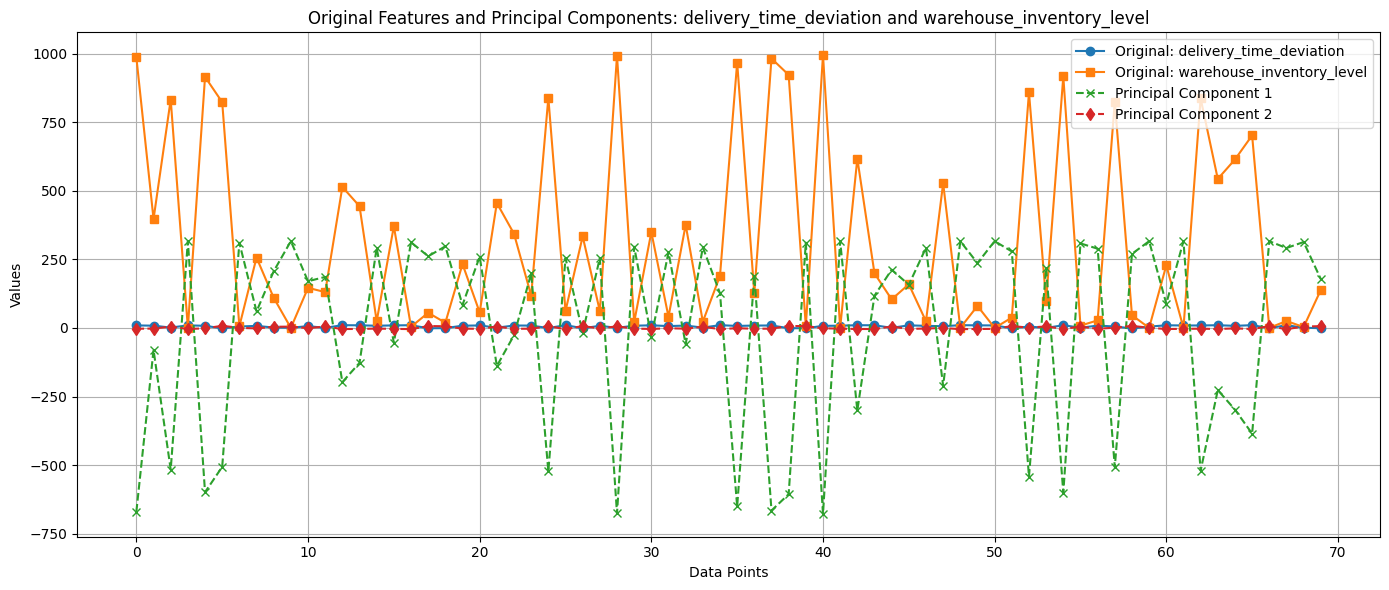


Pair: ('delivery_time_deviation', 'warehouse_inventory_level')
Eigenvalues:
[1.19646732e+05 1.77490725e+01]

Eigenvectors:
[[-8.00622533e-04 -9.99999680e-01]
 [-9.99999680e-01  8.00622533e-04]]

Angle between eigenvectors: 90.00 degrees
Variance explained by the first principal component: 99.99%


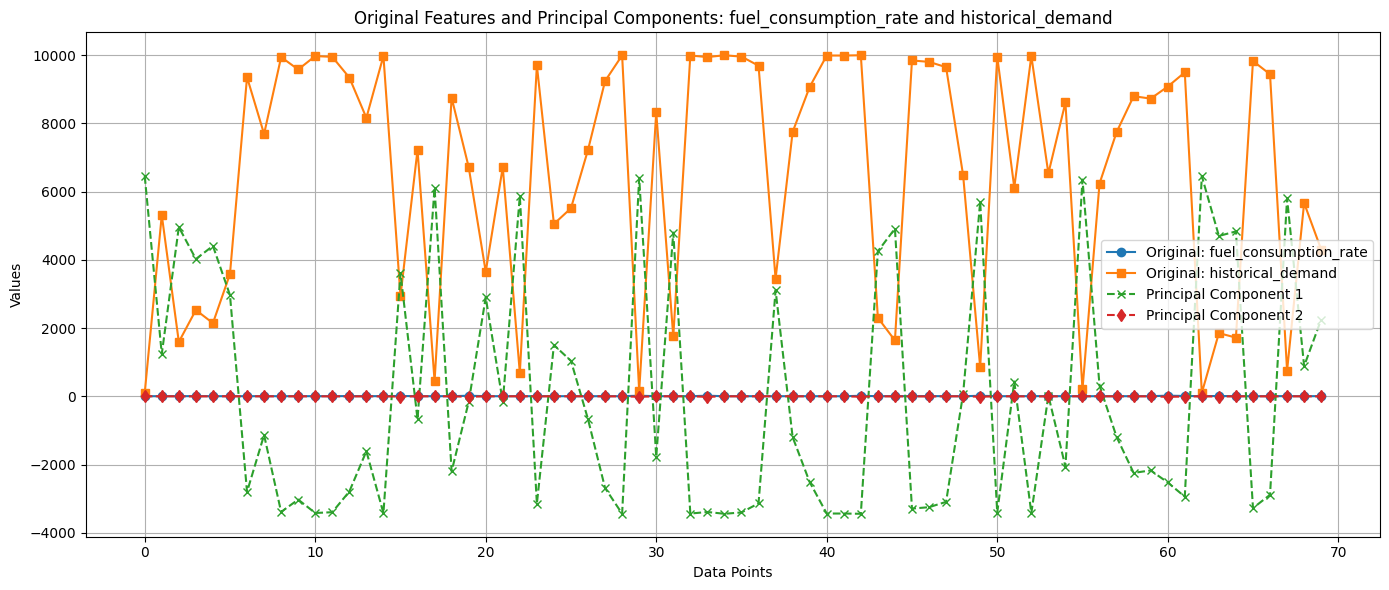


Pair: ('fuel_consumption_rate', 'historical_demand')
Eigenvalues:
[1.21873789e+07 1.59381928e+01]

Eigenvectors:
[[ 8.65712568e-05 -9.99999996e-01]
 [-9.99999996e-01 -8.65712568e-05]]

Angle between eigenvectors: 90.00 degrees
Variance explained by the first principal component: 100.00%


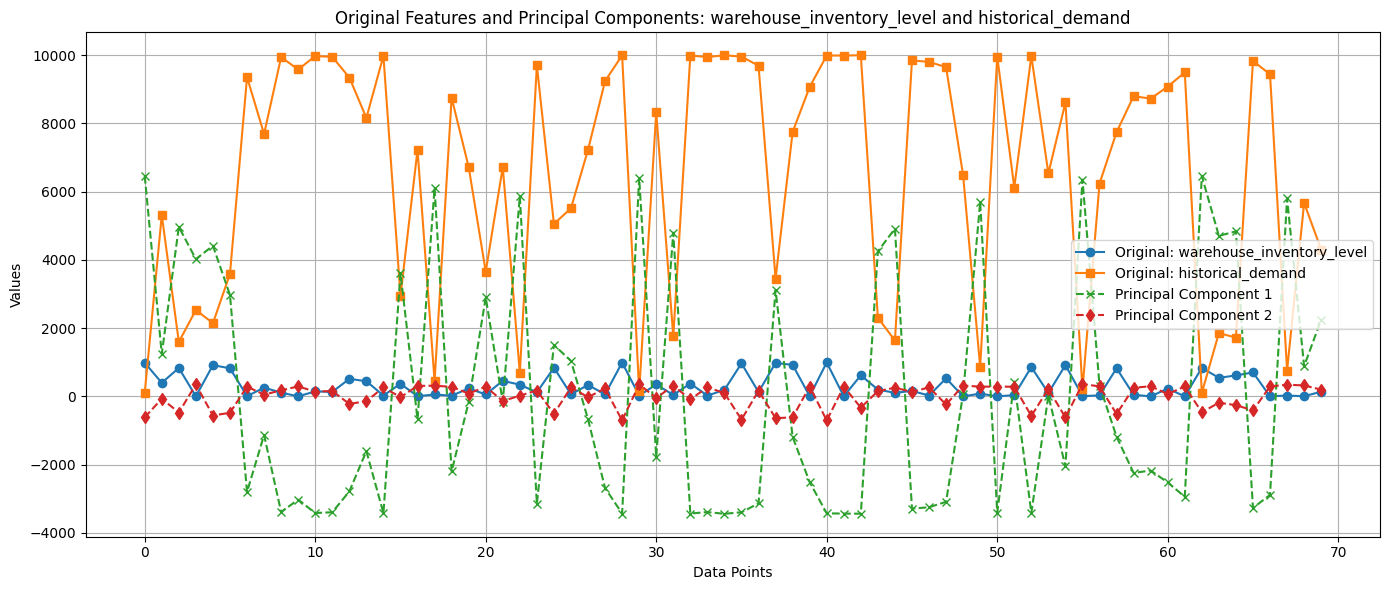


Pair: ('warehouse_inventory_level', 'historical_demand')
Eigenvalues:
[12188261.66222722   118763.80930768]

Eigenvectors:
[[ 0.00855259 -0.99996343]
 [-0.99996343 -0.00855259]]

Angle between eigenvectors: 90.00 degrees
Variance explained by the first principal component: 99.03%


In [24]:

# Select relevant numeric features for PCA
features = ['delivery_time_deviation', 'fuel_consumption_rate', 
            'warehouse_inventory_level', 'historical_demand']

# Drop rows with missing values
data_pca = data[features].dropna().dropna().iloc[:70]

# Ensure rows are properly indexed
data_pca.index = np.arange(len(data_pca))

# ----------------------------- PCA Function -----------------------------
def perform_pca(pair, data):
    # Extract data for the feature pair
    X = data[list(pair)].values
    rows = np.arange(len(X))
    
    # Step 1: Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Step 2: Compute the covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Step 3: Find eigenvalues and eigenvectors
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eig_values.argsort()[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    
    # Step 4: Calculate the angle between the first two eigenvectors
    dot_product = np.dot(eig_vectors[:, 0], eig_vectors[:, 1])
    norms = np.linalg.norm(eig_vectors[:, 0]) * np.linalg.norm(eig_vectors[:, 1])
    cos_theta = dot_product / norms
    angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    
    # Step 5: Fraction of variance explained by the first eigenvector
    variance_explained = eig_values[0] / np.sum(eig_values)
    
    # Step 6: Project the data onto the principal components
    principal_components = np.dot(X_centered, eig_vectors)
    
    # ----------------------------- Plot Results -----------------------------
    plt.figure(figsize=(14, 6))
    
    # Original features
    plt.plot(rows, X[:, 0], label=f'Original: {pair[0]}', linestyle='-', marker='o')
    plt.plot(rows, X[:, 1], label=f'Original: {pair[1]}', linestyle='-', marker='s')
    
    # Principal components
    plt.plot(rows, principal_components[:, 0], label='Principal Component 1', linestyle='--', marker='x')
    plt.plot(rows, principal_components[:, 1], label='Principal Component 2', linestyle='--', marker='d')
    
    plt.title(f"Original Features and Principal Components: {pair[0]} and {pair[1]}")
    plt.xlabel("Data Points")
    plt.ylabel("Values")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\nPair: {pair}")
    print("Eigenvalues:")
    print(eig_values)
    print("\nEigenvectors:")
    print(eig_vectors)
    print(f"\nAngle between eigenvectors: {angle_deg:.2f} degrees")
    print(f"Variance explained by the first principal component: {variance_explained * 100:.2f}%")

# ----------------------------- Run PCA for Feature Pairs -----------------------------
# Define pairs of features to analyze
pairs = [
    ('delivery_time_deviation', 'fuel_consumption_rate'),
    ('delivery_time_deviation', 'warehouse_inventory_level'),
    ('fuel_consumption_rate', 'historical_demand'),
    ('warehouse_inventory_level', 'historical_demand')
]

# Perform PCA for each pair
for pair in pairs:
    perform_pca(pair, data_pca)